In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from string import punctuation

warnings.filterwarnings("ignore")
pd.set_option('max_columns', None)

## Data description
GameId - a unique game identifier<br/>
PlayId - a unique play identifier<br/>
Team - home or away<br/>
X - player position along the long axis of the field. See figure below.<br/>
Y - player position along the short axis of the field. See figure below.<br/>
S - speed in yards/second<br/>
A - acceleration in yards/second^2<br/>
Dis - distance traveled from prior time point, in yards<br/>
Orientation - orientation of player (deg)<br/>
Dir - angle of player motion (deg)<br/>
NflId - a unique identifier of the player<br/>
DisplayName - player's name<br/>
JerseyNumber - jersey number<br/>
Season - year of the season<br/>
YardLine - the yard line of the line of scrimmage<br/>
Quarter - game quarter (1-5, 5 == overtime)<br/>
GameClock - time on the game clock<br/>
PossessionTeam - team with possession<br/>
Down - the down (1-4)<br/>
Distance - yards needed for a first down<br/>
FieldPosition - which side of the field the play is happening on<br/>
HomeScoreBeforePlay - home team score before play started<br/>
VisitorScoreBeforePlay - visitor team score before play started<br/>
NflIdRusher - the NflId of the rushing player<br/>
OffenseFormation - offense formation<br/>
OffensePersonnel - offensive team positional grouping<br/>
DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line<br/>
DefensePersonnel - defensive team positional grouping<br/>
PlayDirection - direction the play is headed<br/>
TimeHandoff - UTC time of the handoff<br/>
TimeSnap - UTC time of the snap<br/>
<br/>
**Yards - the yardage gained on the play (you are predicting this)**<br/>
<br/>
PlayerHeight - player height (ft-in)<br/>
PlayerWeight - player weight (lbs)<br/>
PlayerBirthDate - birth date (mm/dd/yyyy)<br/>
PlayerCollegeName - where the player attended college<br/>
Position - the player's position (the specific role on the field that they typically play)<br/>
HomeTeamAbbr - home team abbreviation<br/>
VisitorTeamAbbr - visitor team abbreviation<br/>
Week - week into the season<br/>
Stadium - stadium where the game is being played<br/>
Location - city where the game is being player<br/>
StadiumType - description of the stadium environment<br/>
Turf - description of the field surface<br/>
GameWeather - description of the game weather<br/>
Temperature - temperature (deg F)<br/>
Humidity - humidity<br/>
WindSpeed - wind speed in miles/hour<br/>
WindDirection - wind direction<br/>


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_football_field(ax,
                          linenumbers=True,
                          endzones=True,
                          line_gap = 10,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    # fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    ax.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
            80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
            53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color='white')
    if fifty_is_los:
        ax.plot([60, 60], [0, 53.3], color='gold')
        ax.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.set_xlim(0, 120)
    ax.set_ylim(-5, 58.3)
    ax.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(x, 5, str(numb - 10),
                    horizontalalignment='center',
                    fontsize=20,  # fontname='Arial',
                    color='white')
            ax.text(x - 0.95, 53.3 - 5, str(numb - 10),
                    horizontalalignment='center',
                    fontsize=20,  # fontname='Arial',
                    color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + line_gap
        ax.plot([hl, hl], [0, 53.3], color='yellow')
        ax.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                color='yellow')
    return ax


## Read data and check info

In [3]:
input_dir = os.path.join('../input', 'nfl-big-data-bowl-2020')
train_path = os.path.join(input_dir, 'train.csv')
use_columns = []

In [45]:
df = pd.read_csv(train_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

In [27]:
def process_dist_with_rusher(df):
    def get_dist(x1, y1, x2, y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2
        return np.sqrt(x_diff + y_diff)
    
    def dist_to_section(dist):
        if dist < 4:
            return 7
        elif dist < 6:
            return 6
        elif dist < 9:
            return 5
        elif dist < 11:
            return 4
        elif dist < 15:
            return 3
        elif dist < 18:
            return 2
        elif dist < 22:
            return 1
        else:
            return 0
        
    dist_with_rusher = df[['GameId', 'PlayId', 'X', 'Y']]
    dist_with_rusher = pd.merge(dist_with_rusher,
                                df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId', 'X', 'Y']],
                                on=['GameId', 'PlayId'],
                                how='left')
    dist_with_rusher.columns = ['GameId', 'PlayId', 'X', 'Y', 'rusherX', 'rusherY']
    df['Dist_with_Rusher'] = dist_with_rusher[['X', 'Y', 'rusherX', 'rusherY']].apply(lambda x: get_dist(x[0], x[1], x[2], x[3]), axis=1)
    df['Dist_with_Rusher_Sec'] = df['Dist_with_Rusher'].apply(lambda x: dist_to_section(x))
    return df
df = process_dist_with_rusher(df)

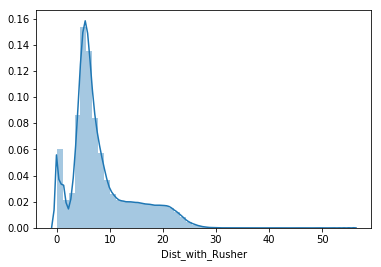

In [28]:
sns.distplot(df['Dist_with_Rusher'])

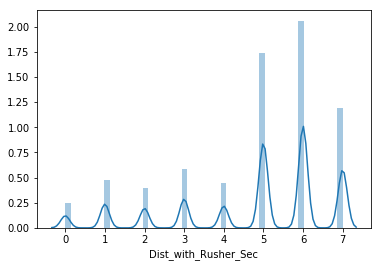

In [29]:
sns.distplot(df['Dist_with_Rusher_Sec'])

# YardLine

In [14]:
def new_line(rush_team, field_position, yardline):
    if rush_team == field_position:
        # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
        return 10.0 + yardline
    else:
        # half the field plus the yards between midfield and the line of scrimmage
        return 60.0 + (50 - yardline)
    
df['yardline_fix'] = df[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)

 

In [15]:
df[['yardline_fix']].describe()

,yardline_fix
count,509762.000000
mean,57.961849
std,25.160334
min,11.000000
25%,36.000000
50%,54.000000
75%,78.000000
max,109.000000


## Check Columns
<br/>
check the relationships with playid and other columns

## 1. Yards (target)

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Yards'], kde=True)
plt.axvline(df['Yards'].mean(), 0, 1, c='r')

## 2. Stadium
<br/>
- [add columns - LocDegree]check stadium location and get degree<br/>
- normalizing stadium name

In [ ]:
map_stadium = {'CenturyLink': 'CenturyLink', 'CenturyLink Field': 'CenturyLink', 'Everbank Field': 'EverBank Field',
               'First Energy Stadium': 'FirstEnergy Stadium', 'FirstEnergy': 'FirstEnergy Stadium', 'FirstEnergyStadium': 'FirstEnergy Stadium',
               'Lambeau field': 'Lambeau Field', 'Los Angeles Memorial Coliesum': 'Los Angeles Memorial Coliseum',
               'M & T Bank Stadium': 'M&T Bank Stadium', 'M&T Stadium': 'M&T Bank Stadium', 'MetLife': 'MetLife Stadium',
               'Metlife Stadium': 'MetLife Stadium', 'NRG': 'NRG Stadium', 'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum',
               'Paul Brown Stdium': 'Paul Brown Stadium', 'Twickenham': 'Twickenham Stadium', 'Broncos Stadium At Mile High': 'Empower Field at Mile High',
               'Sports Authority Field at Mile High': 'Empower Field at Mile High', 'CenturyField': 'CenturyLink',
               'Mercedes-Benz Dome': 'Mercedes-Benz Stadium', 'Broncos Stadium at Mile High': 'Empower Field at Mile High',
               'TIAA Bank Field': 'EverBank Field', 'Gillette Stadium': 'Gillette Stadium', 'New Era Field': 'New Era Field',
               'Soldier Field': 'Soldier Field', 'Paul Brown Stadium': 'Paul Brown Stadium', 'Ford Field': 'Ford Field',
               'NRG Stadium': 'NRG Stadium', 'Nissan Stadium': 'Nissan Stadium', 'FedExField': 'FedExField',
               'Los Angeles Memorial Coliseum': 'Los Angeles Memorial Coliseum', 'Lambeau Field': 'Lambeau Field', 'Levis Stadium': 'Levis Stadium',
               'AT&T Stadium': 'AT&T Stadium', 'U.S. Bank Stadium': 'U.S. Bank Stadium', 'M&T Bank Stadium': 'M&T Bank Stadium',
               'Bank of America Stadium': 'Bank of America Stadium', 'Lucas Oil Stadium': 'Lucas Oil Stadium', 'Arrowhead Stadium': 'Arrowhead Stadium',
               'Mercedes-Benz Superdome': 'Mercedes-Benz Superdome', 'Heinz Field': 'Heinz Field', 'Raymond James Stadium': 'Raymond James Stadium',
               'StubHub Center': 'StubHub Center', 'Oakland-Alameda County Coliseum': 'Oakland-Alameda County Coliseum',
               'MetLife Stadium': 'MetLife Stadium', 'Wembley Stadium': 'Wembley Stadium', 'Lincoln Financial Field': 'Lincoln Financial Field',
               'University of Phoenix Stadium': 'University of Phoenix Stadium', 'Mercedes-Benz Stadium': 'Mercedes-Benz Stadium',
               'FirstEnergy Stadium': 'FirstEnergy Stadium', 'Hard Rock Stadium': 'Hard Rock Stadium', 'EverBank Field': 'EverBank Field',
               'Twickenham Stadium': 'Twickenham Stadium', 'Estadio Azteca': 'Estadio Azteca', 'State Farm Stadium': 'State Farm Stadium'}

In [ ]:
print('[*]Unique size before mapping Stadium: {}'.format(len(df['Stadium'].unique())))
df['Stadium'] = df['Stadium'].map(map_stadium)
print('[*]Unique size After mapping Stadium: {}'.format(len(df['Stadium'].unique())))

In [ ]:
#print('[*]Unique size LocDegree: {}'.format(len(df['LocDegree'].unique())))

## 3. StadiumType
- processing to [indoor, outdoor, open, closed]

In [ ]:
df['StadiumType'].unique()

In [ ]:
def transport_StadiumType(txt):
    import re
    rs = 'outside'
    if pd.isna(txt):
        return rs
    txt = txt.lower()
    txt = ''.join([x for x in txt if x.isalpha()])
    if 'ou' in txt:
        rs = 'outside'
    elif 'in' in txt:
        rs = 'inside'
    elif 'ope' in txt:
        rs = 'opened'
    else:
        rs = 'closed'
    return rs

In [ ]:
df['StadiumType'] = df['StadiumType'].apply(transport_StadiumType)
use_columns.append('StadiumType')
df['StadiumType'].isnull().sum()

## 4. Location
- unique location per unique stadium

각 게임(GameId)당 여러번의 경기(PlayId)를 한다.<br/>
경기(PlayId) 마다 선수(displayName)은 동일하나 교체가 될 경우 다를 수 있다.<br/>
각 게임(GameId)당 쿼터(Quarter)는 1~5 사이에 속한다.<br/>
각 경기는 PlayDirection과 PossessionTeam이 같고 게임의 경기마다 바뀐다(전후반 위치 전환)<br/>
Stadium 위도경도를 찾는다(WindDirection 관계를 위해서)<br/>
WindSpeed, WindDirection이 모두 null인 경우 바람이 없는 것으로 간주한다<br/>
WindSpeed가 0인 경우 기본적으로 바람의 방향은 없는 것으로 간주한다<br/>
WindSpeed는 해당 월의 평균 WinSpeed로 대체한다.<br/>
WindDirection 은 해당 Stadium의 most_values로 대체한다.<br/>
WindDirection: 16방위<br/>
<br/>
**PlayId가 같을 때 같은 데이터**<br/>
- OffensePersonnel

## 5. GameId

In [ ]:
df['Year'] = df['GameId'].apply(lambda x: str(x)[0:4]).astype(str)
df['Month'] = df['GameId'].apply(lambda x: str(x)[4:6]).astype(str)
use_columns.append('Year')
use_columns.append('month')

## 6. WindSpeed

In [ ]:
df['WindSpeed'] = df['WindSpeed'].astype(str)
df['WindDirection'] = df['WindDirection'].astype(str)

In [ ]:
df['WindSpeed'].unique()

In [ ]:
df['WindDirection'].unique()

In [ ]:
#somre rows are swapped between WindDirection and WindSpeed
def transport_WindSpeed(row, fillna=5):
    speed = row['WindSpeed']
    direction = row['WindDirection']
    #둘 다 없을 때
    if pd.isna(speed) and pd.isna(direction):
        row['WindSpeed'] = 0
        row['WindDirection'] = 'calm'
    #speed만 없을 때
    elif pd.isna(row['WindSpeed']):
        row['WindSpeed'] = fillna
        return row
    #speed가 있고 direction이 있거나 없을 때
    if type(speed) == str and speed.isalpha():
        #direction이 값이 있고 숫자이면
        if not pd.isna(direction) and str(direction[0]).isdigit():
            row['WindDirection'], row['WindSpeed'] = speed, direction
        
        elif 'calm' in speed.lower():
            row['WindSpeed'] = 0
            row['WindDirection'] = 'calm'
            
    speed = str(speed)
    speed = ''.join([x if (x.isdigit() or x=='.') else ' ' for x in speed ])
    if len(speed.split()) > 1:
        speed = int(float(speed.split()[0])) + int(float(speed.split()[-1]))
        speed = speed//2
    else:
        speed = int(float(speed)) if speed[0].isdigit() else fillna
    row['WindSpeed'] = speed
    return row

In [ ]:
df[['WindSpeed', 'WindDirection']] = df[['WindSpeed', 'WindDirection']].apply(transport_WindSpeed, axis=1)
df['WindSpeed'] = df['WindSpeed'].astype(np.float)
use_columns.append('WindSpeed')
df['WindSpeed'].isnull().sum()

In [ ]:
#check mean WindSpeed of each StadiumType
speed_by_stadiumtype = pd.DataFrame(df.groupby(['StadiumType'], as_index=False)['WindSpeed'].mean())
fig = plt.figure(figsize=(20, 3))
plt.plot(speed_by_stadiumtype['StadiumType'], speed_by_stadiumtype['WindSpeed'].values)

In [ ]:
#check mean WindSpeed of each Month
speed_by_month = pd.DataFrame(df.groupby(['Month'], as_index=False)['WindSpeed'].mean())
fig = plt.figure(figsize=(20, 3))
plt.plot(speed_by_month['Month'], speed_by_month['WindSpeed'].values)

In [ ]:
#check mean WindSpeed of each Stadium and each Month
fig = plt.figure(figsize=(30, 3))
speed_by_stadium = pd.DataFrame()
speed_by_stadium['Stadium'] = df['Stadium'].unique()
for month in ['09', '10', '11', '12']:
    month_data = pd.DataFrame(df[df['Month']== month].groupby(['Stadium'], as_index=False)['WindSpeed'].mean())
    month_data.columns = ['Stadium', month]
    speed_by_stadium = pd.merge(speed_by_stadium, month_data, on='Stadium', how='left')
fig = plt.figure(figsize=(20, 3))
plt.plot(speed_by_stadium['Stadium'], speed_by_stadium['09'])
plt.plot(speed_by_stadium['Stadium'], speed_by_stadium['10'])
plt.plot(speed_by_stadium['Stadium'], speed_by_stadium['11'])
plt.plot(speed_by_stadium['Stadium'], speed_by_stadium['12'])

In [ ]:
def fill_windspeed_by_month(row):
    month = row['Month']
    speed = speed_by_month[speed_by_month['Month']==month]['WindSpeed'].values[0]
    row['WindSpeed'] = speed
    return row

In [ ]:
#df[df['WindSpeed'].isnull()] = df[df['WindSpeed'].isnull()].apply(fill_windspeed_by_month, axis=1)
#df['WindSpeed'] = df['WindSpeed'].astype(np.float)

## 7. WindDirection

In [ ]:
df['WindDirection'].unique()

In [ ]:
def cleaning_direction(txt, fillna="calm"):
    
    if pd.isna(txt):
        txt = fillna
    
    tmp = txt.lower()
    tmp = ''.join([s for s in tmp if s not in punctuation])
    tmp = tmp.replace("from", "")
    tmp = tmp.replace("to", "")
    flag = tmp.strip()
    
    tmp = tmp.replace("north", "North")
    tmp = tmp.replace("east", "East")
    tmp = tmp.replace("south", "South")
    tmp = tmp.replace("west", "West")
    tmp = tmp.replace("calm", "Calm")
    tmp = ''.join([x for x in tmp if x.isalpha() and x.isupper()])
    rs = ''
    if len(flag) < 4:
        rs = flag.upper()
    else:
        rs = tmp
    
    if rs.count('N') == 1:
        
        if rs.count('E') == 1:
            rs = 'NE'
        elif rs.count('W') == 1:
            rs = 'NW'
        elif rs.count('W') == 2:
            rs = 'WNW'
        elif rs.count('E') == 2:
            rs = 'ENE'
        else:
            rs = 'N'
    elif rs.count('N') == 2:
        if rs.count('W') == 1:
            rs = 'NNW'
        elif rs.count('E') == 1:
            rs = 'NNE'
        else:
            rs = 'N'
    elif rs.count('S') == 1:
        if rs.count('E') == 1:
            rs = 'SE'
        elif rs.count('W') == 1:
            rs = 'SW'
        elif rs.count('W') == 2:
            rs = 'WSW'
        elif rs.count('E') == 2:
            rs = 'ESE'
        else:
            rs = 'S'
    elif rs.count('S') == 2:
        if rs.count('W') == 1:
            rs = 'SSW'
        elif rs.count('E') == 1:
            rs = 'SSE'
        else:
            rs = 'S'
    elif rs.count('W'):
        rs = 'W'
    elif rs.count('E'):
        rs = 'E'
    else:
        rs = 'C'
    return rs

In [ ]:
df['WindDirection'] = df['WindDirection'].apply(cleaning_direction)
use_columns.append('WindDirection')
df['WindDirection'].isnull().sum()

In [ ]:
most_winddirection_by_stadium = pd.DataFrame(columns=['Direction'])
for stadium in df['Stadium'].unique():
    most_winddirection_by_stadium.loc[stadium, 'Direction'] = df[df['Stadium']==stadium]['WindDirection'].value_counts().index[0]

In [ ]:
most_winddirection_by_stadium

In [ ]:
#somre rows are swapped between WindDirection and WindSpeed
def fill_winddirection_by_stadium(row):
    stadium = row['Stadium']
    return most_winddirection_by_stadium.loc[stadium].values[0]
#df[['WindDirection']] = df[['Stadium']].apply(fill_winddirection_by_stadium, axis=1)

## Temperature & Humidity

In [ ]:
#같은 월일 때 Stadium별로 기온의 편차가 심하지 않다. 기온은 Stadium(위치) 보다는 Month의 영향을 크게 받는다.
pd.DataFrame(df[df['Month']=='09'].groupby(['Stadium'], as_index=False)['Temperature'].mean()).describe()

In [ ]:
#check mean WindSpeed of each Month
temperature_by_month = pd.DataFrame(df.groupby(['Month'], as_index=False)['Temperature'].mean())
fig = plt.figure(figsize=(20, 3))
plt.plot(temperature_by_month['Month'], temperature_by_month['Temperature'].values)

In [ ]:
temperature_by_month

In [ ]:
def transform_temperature(row):
    if pd.isna(row['Temperature']):
        month = row['Month']
        temp = 60
        if month == '09':
            temp = 75
        elif month == '10':
            temp = 66
        elif month == '11':
            temp = 56
        elif month == '12':
            temp = 49
        row['Temperature'] = temp
        return row['Temperature']
    else:
        return row['Temperature']
df['Temperature'] = df[['Month','Temperature']].apply(transform_temperature, axis=1).astype(np.float)
use_columns.append('Temperature')

In [ ]:
def fill_temperature_by_month(row):
    month = row['Month']
    temperature = temperature_by_month[temperature_by_month['Month']==month]['Temperature'].values[0]
    row['Temperature'] = temperature
    return row
#df[df['Temperature'].isnull()] = df[df['Temperature'].isnull()].apply(fill_temperature_by_month, axis=1)
#df['Temperature'] = df['Temperature'].astype(np.float)
print('done')

In [ ]:
#같은 월일 때 Stadium별로 습도의 편차가 심하다. 기온은 Stadium(위치) 의 영향을 크게 받는다.
pd.DataFrame(df[df['Month']=='09'].groupby(['Stadium'], as_index=False)['Humidity'].mean()).describe()

In [ ]:
humidity_by_stadium = pd.DataFrame(df.groupby(['Stadium'], as_index=False)['Humidity'].mean())

In [ ]:
def fill_humidity_by_stadium(row):
    stadium = row['Stadium']
    humidity = humidity_by_stadium[humidity_by_stadium['Stadium']==stadium]['Humidity'].values[0]
    row['Humidity'] = humidity
    return row
#df[df['Humidity'].isnull()] = df[df['Humidity'].isnull()].apply(fill_humidity_by_stadium, axis=1)
#df['Humidity'] = df['Humidity'].astype(np.float)
print('done')

## Turf

In [ ]:
def transform_temperature(col):
    turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
    rs = col.map(turf)
    return df['Turf'] == 'Natural'

In [ ]:
#from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
df['Turf'] = df[['Turf']].apply(transform_temperature)

In [ ]:
sum(df['Turf']==False), sum(df['Turf']==True), 

## GameWeather

In [ ]:
df['GameWeather'].unique()

In [ ]:
#transform to --> [cloudy, sunny, rainy, warm, cold]

In [ ]:
cloudy_list = ['clou', 'hazy', 'wind', 'overcast', 'fog']
clear_list = ['clear', 'sun', 'indoor', '']
rainy_list = ['rain','shower']
snow_list = ['snow']
warm_list = ['warm']
cold_list = ['cold', 'cool']

In [ ]:
def clean_weather_warm(txt):
    point = 0
    if pd.isna(txt):
        return point
    txt = txt.lower()
    for t in txt.split():
        if t in warm_list:
            point *= 2
        if t in cold_list:
            point -= 1
        if t in snow_list:
            point -= 1
    return point

In [ ]:
#df['isWarm'] = df['GameWeather'].apply(clean_weather_warm)

In [ ]:
def clean_weather(txt):
    point = 0
    if pd.isna(txt):
        return point
    txt = txt.lower()
    for t in txt.split():
        if t in snow_list:
            point -= 3
        if t in rainy_list:
            point -= 2
        if t in cloudy_list:
            point -= 1
        if t in clear_list:
            point += 3
    return point

In [ ]:
df['GameWeather'] = df['GameWeather'].apply(clean_weather).astype(np.float)
use_columns.append('GameWeather')

## Possession Team

https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win

In [110]:
df = pd.read_csv(train_path)

In [17]:
def new_line(rush_team, field_position, play_direction, yardline):
    
    if rush_team == field_position:
        # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
        if play_direction == 'left':
            return 100 - yardline + 10
        return yardline + 10
    else:
        # half the field plus the yards between midfield and the line of scrimmage
        if play_direction == 'left':
            return yardline + 10
        return 100 -  yardline + 10

def update_yardline(df):
    new_yardline = df[df['NflId'] == df['NflIdRusher']]
    new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','PlayDirection','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2],x[3]), axis=1)
    new_yardline = new_yardline[['GameId','PlayId','YardLine']]

    return new_yardline
new_yardline = update_yardline(df)

In [18]:
df = df.drop(['YardLine'], axis=1)
df = pd.merge(df, new_yardline, on=['GameId','PlayId'], how='inner')

In [ ]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in df['PossessionTeam'].unique():
    map_abbr[abb] = abb

## GameClock

In [ ]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans
#df['GameClock'] = df['GameClock'].apply(strtoseconds)

## PlayerHeight

In [ ]:
df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

In [ ]:
#Add Col
df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight'])**2)

## GameClock

In [ ]:
df[['GameClock', 'TimeHandoff', 'TimeSnap']].head(1)

In [ ]:
import datetime
df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

In [ ]:
df['TimeDelta_snap'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)

In [ ]:
df['TimeDelta'] = df['TimeHandoff'].apply(lambda row: row.hour*3600 + row.minute*60 + row.second)

## Player Birthdate

In [ ]:
df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [ ]:
seconds_in_year = 60*60*24*365.25
df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

In [ ]:
df.head(3)

In [ ]:
df = df.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

## Team

In [ ]:
df['Team'] = df['Team'].apply(lambda x: x.strip() == 'home')

In [ ]:
df['HomeField'] = df['FieldPosition'] == df['HomeTeamAbbr']

## NflId

In [ ]:
df['IsRusher'] = df['NflId'] == df['NflIdRusher']
df.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

## YardsLeft

In [ ]:
df['YardsLeft'] = df.apply(lambda row: 100-int(row['YardLine']) if row['HomeField'] else int(row['YardLine']), axis=1)

In [ ]:
df['YardsLeft'] = df.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

In [ ]:
orientation_nan_playid = df[df['Orientation'].isnull()]['PlayId'].unique()

In [ ]:
orientation_by_play = pd.DataFrame(columns = ['OrientationAVG'])
for play in orientation_nan_playid:
    avg = df[df['PlayId']==play]['Orientation'].mean()
    orientation_by_play.loc[play] = avg
orientation_by_play

In [ ]:
def fill_orientation_by_game(row):
    playid = row['PlayId']
    row['Orientation'] = orientation_by_play.loc[playid, 'OrientationAVG']
    return row
df[df['Orientation'].isnull()] = df[df['Orientation'].isnull()].apply(fill_orientation_by_game, axis=1)
df['Orientation'] = df['Orientation'].astype(np.float)
print('done')

In [ ]:
dir_nan_playid = df[df['Dir'].isnull()]['PlayId'].unique()
dir_by_play = pd.DataFrame(columns = ['DirAVG'])
for play in dir_nan_playid:
    avg = df[df['PlayId']==play]['Dir'].mean()
    dir_by_play.loc[play] = avg
dir_by_play

In [ ]:
def fill_dir_by_game(row):
    playid = row['PlayId']
    row['Dir'] = dir_by_play.loc[playid, 'DirAVG']
    return row
df[df['Dir'].isnull()] = df[df['Dir'].isnull()].apply(fill_dir_by_game, axis=1)
df['Dir'] = df['Dir'].astype(np.float)
print('done')

## FieldPosition

In [ ]:
for gameid in df[df['FieldPosition'].isnull()]['GameId'].unique():
    val = df[df['GameId']==gameid]['FieldPosition'].value_counts().index[0]
    idx = df[df['GameId']==gameid][df['FieldPosition'].isnull()].index
    df.loc[idx, 'FieldPosition'] = val
print('done')

## OffenseFormation

In [ ]:
for gameid in df[df['OffenseFormation'].isnull()]['GameId'].unique():
    val = df[df['GameId']==gameid]['OffenseFormation'].value_counts().index[0]
    idx = df[df['GameId']==gameid][df['OffenseFormation'].isnull()].index
    df.loc[idx, 'OffenseFormation'] = val
print('done')

In [ ]:
for gameid in df[df['OffenseFormation'].isnull()]['GameId'].unique():
    val = df[df['GameId']==gameid]['OffenseFormation'].value_counts().index[0]
    idx = df[df['GameId']==gameid][df['OffenseFormation'].isnull()].index
    df.loc[idx, 'OffenseFormation'] = val
print('done')

In [ ]:
df['DefendersInTheBox'] = df['DefendersInTheBox'].fillna(7.0)

In [ ]:
df['Month'] = df['Month'].astype(np.float)
df['Year'] = df['Year'].astype(np.float)

In [ ]:
df = df.drop(['GameId', 'PlayId', 'DisplayName', 'GameClock', 'DefensePersonnel'], axis=1)

In [ ]:
for col in df.columns:
    if df[col].dtypes == 'object':
        one_hot = pd.get_dummies(df[col]) 
        df = pd.concat([df.drop([col], axis=1), pd.get_dummies(df[col], prefix=col+'_')], axis=1)
    elif df[col].dtypes == 'bool':
        df[col] = df[col].astype(np.int)

## Jersey
1 - 19:     Quarterbacks, punters, and kickers<br/>
20 - 49:   Running backs and defensive backs<br/>
50 - 59:   Centers<br/>
60 - 79:   Defensive linemen and offensive linemen<br/>
80 - 89:   Receivers and tight ends<br/>
90 - 99:   Defensive linemen and linebackers<br/>


In [ ]:

jersey = df[df['NflId'] == df['NflIdRusher']][['JerseyNumber', 'Yards']]
def change_num(num):
    if 1<=num<=19:
        return 6
    elif 20<=num<=49:
        return 4
    elif 50<=num<=59:
        return 3
    elif 60<=num<=79:
        return 1
    elif 80<=num<=89:
        return 5
    else:
        return 2
jersey['JerseyNumber'] = jersey['JerseyNumber'].apply(change_num)
jersey.groupby(['JerseyNumber'])['Yards'].mean()

In [ ]:
jersey['JerseyNumber'].value_counts()